# 1.2: Data Acquisition

**Objective:** To programmatically and reproducibly download all necessary raw data for the project, including Digital Elevation Models (DEMs), climate data, and soil properties. This notebook is designed to be idempotent, meaning it can be run multiple times without re-downloading existing files.

**Workflow:** Each dataset follows a consistent pattern:
1. **Pre-flight Check** - Verify if data already exists and is valid
2. **Download** - Acquire data using cloud-native methods (STAC/Zarr)
3. **Post-flight Validation** - Verify download completeness and data quality

**Gold-Standard Practices:**
- **Configuration-Driven:** All paths, data sources, and parameters loaded from `config.yml`
- **System-Aware Parallelism:** Concurrent downloads based on CPU cores
- **Idempotent & Resilient:** Pre-flight checks skip existing files; retry mechanism for network errors
- **Atomic Writes:** Files downloaded to `.part` then renamed on success
- **Provenance Tracking:** JSON metadata sidecar for each downloaded file
- **Cloud-Native Discovery:** STAC-based queries (no hardcoded URLs)
- **Validation:** Post-flight checks ensure data completeness and correctness

**Data Source**
USGS 3DEP via Planetary Computer STAC

In [4]:
# === 1. Configuration & Setup ===

# --- Core Libraries ---
from __future__ import annotations

import logging
import math
import re
import sys
from pathlib import Path
from shapely.geometry import box  # <-- This is the key import we will use
import yaml
import geopandas as gpd
import pandas as pd
import psutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import contextily as ctx

# --- Project-Specific Modules ---
# Add project's src directory to path to allow imports
def find_project_root(marker='config.yml'):
    path = Path.cwd().resolve()
    while path.parent != path:
        if (path / marker).exists():
            return path
        path = path.parent
    raise FileNotFoundError(f"Project root with marker '{marker}' not found.")

PROJECT_ROOT = find_project_root()
if str(PROJECT_ROOT / 'src') not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT / 'src'))

# Import from reorganized src structure
from geo_tda.data_acquisition import build_dem_download_jobs_stac, execute_downloads
from geo_tda.utils import get_key_from_sw_corner, setup_colored_logging

# --- Gold-Standard Logging Setup ---
setup_colored_logging()
log = logging.getLogger("1.2_data_acquisition")

# --- Configuration Loading ---
CONFIG_PATH = PROJECT_ROOT / "config.yml"
with open(CONFIG_PATH) as f:
    config = yaml.safe_load(f)

# --- Path Configuration (from config) ---
STUDY_AREAS_GPKG = PROJECT_ROOT / config['paths']['study_areas']
EXTERNAL_HOLDOUT_GPKG = PROJECT_ROOT / config['paths']['external_holdout']
MASTER_AOI_GPKG = PROJECT_ROOT / config['paths']['master_aoi']
DEM_OUT_DIR = PROJECT_ROOT / config['paths']['dem_dir']
REPORTS_DIR = PROJECT_ROOT / config['paths']['outputs_dir'] / 'data_acquisition'

for p in [DEM_OUT_DIR, REPORTS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# --- Data Source & Parameter Configuration (from config) ---
PC_STAC_URL = config['data_sources']['dem']['stac_url']
DEM_COLLECTION = config['data_sources']['dem']['collection']
DEM_ASSET_KEY = config['data_sources']['dem']['asset_key']
DEM_GSD = config['data_sources']['dem']['gsd']
WGS84_CRS = config['parameters']['wgs84_crs']

# --- System-Aware Parallelism ---
PHYSICAL_CORES = psutil.cpu_count(logical=False)
MAX_CONCURRENT_DOWNLOADS = max(1, PHYSICAL_CORES if PHYSICAL_CORES is not None else 4)

# --- Plotting Constants (matching notebook 1.1 style) ---
WEB_MAP_CRS = "EPSG:3857"

# --- Log Setup Summary ---
log.info(f"Project Root: {PROJECT_ROOT}")
log.info(f"Output DEM: {DEM_OUT_DIR}")
log.info(f"WGS84 CRS: {WGS84_CRS}")
log.info(f"Concurrent Workers: {MAX_CONCURRENT_DOWNLOADS}")
log.info("✅ Setup complete.")

2025-10-23 14:14:31 - 1.2_data_acquisition - INFO - Project Root: D:\OneDrive - University of Georgia\multiscale_tda_geomorphology
2025-10-23 14:14:31 - 1.2_data_acquisition - INFO - Output DEM: D:\OneDrive - University of Georgia\multiscale_tda_geomorphology\data\raw\dem_30m
2025-10-23 14:14:31 - 1.2_data_acquisition - INFO - WGS84 CRS: EPSG:4326
2025-10-23 14:14:31 - 1.2_data_acquisition - INFO - Concurrent Workers: 14
2025-10-23 14:14:31 - 1.2_data_acquisition - INFO - ✅ Setup complete.


In [8]:
# === 2. Define Master Area of Interest (AOI) ===

# --- FLAG ---
# Set to True to use the simple bounding box defined below.
# Set to False to load the master AOI from the GPKG file (from Notebook 1.1).
USE_SIMPLE_EXTENT = True

# --- Simple Extent Definition ---
# Define your simple extent here in WGS84: [min_lon, min_lat, max_lon, max_lat]
# Example: A small box over part of Athens, GA
SIMPLE_EXTENT_WGS84 = [-85.60674924999249, 30.35909162440624, -80.84375612136121, 35.000591132701324]


if USE_SIMPLE_EXTENT:
    log.info(f"Using simple extent (WGS84): {SIMPLE_EXTENT_WGS84}")

    # 1. Create a shapely geometry from the extent
    bbox_geom = box(
        SIMPLE_EXTENT_WGS84[0],  # min_lon
        SIMPLE_EXTENT_WGS84[1],  # min_lat
        SIMPLE_EXTENT_WGS84[2],  # max_lon
        SIMPLE_EXTENT_WGS84[3]   # max_lat
    )

    # 2. Create the GeoDataFrame
    # The STAC query functions expect a GeoDataFrame, so we create one.
    master_aoi_wgs84 = gpd.GeoDataFrame(
        {'id': [1], 'geometry': [bbox_geom]}, # Add a dummy column
        crs=WGS84_CRS
    )

    log.info("✅ Simple extent AOI created successfully.")

else:
    log.info(f"Loading master AOI from: {MASTER_AOI_GPKG}")

    if not MASTER_AOI_GPKG.exists():
        log.error(f"Master AOI file not found at: {MASTER_AOI_GPKG}")
        raise FileNotFoundError(
            "Master AOI not found. "
            "Please run Notebook 1.1 first or set USE_SIMPLE_EXTENT = True."
        )

    # Load the pre-made AOI and reproject to WGS84 for data queries
    master_aoi_proj = gpd.read_file(MASTER_AOI_GPKG, layer='master_aoi')
    master_aoi_wgs84 = master_aoi_proj.to_crs(WGS84_CRS)

    log.info(f"✅ Master AOI loaded and reprojected to {WGS84_CRS}.")

# --- Visualize ---
log.info("Visualizing the master Area of Interest...")
# explore() works perfectly for either the loaded file or the simple box
master_aoi_wgs84.explore()

2025-10-23 14:34:45 - 1.2_data_acquisition - INFO - Using simple extent (WGS84): [-85.60674924999249, 30.35909162440624, -80.84375612136121, 35.000591132701324]
2025-10-23 14:34:45 - 1.2_data_acquisition - INFO - ✅ Simple extent AOI created successfully.
2025-10-23 14:34:45 - 1.2_data_acquisition - INFO - Visualizing the master Area of Interest...


### Justification for Spatial Intersection Method

To ensure efficiency and minimize unnecessary data downloads, we will not simply download all DEM tiles that fall within the rectangular bounding box of our Area of Interest (AOI). For irregularly shaped study areas like ours, this naive approach would result in downloading numerous tiles that do not actually contain any of our regions.

Instead, we employ a more precise spatial intersection method. This involves:
1.  Generating a complete grid of all possible 1x1 degree tile footprints that cover the AOI's bounding box.
2.  Performing a spatial join (`sjoin`) between these tile footprints and the actual multipolygon of our master AOI.

This operation selects only the tiles that truly intersect our study areas, creating a minimal and precise list of required data. This is a key optimization that enhances the scalability and reproducibility of our workflow.


In [9]:
# === 3. Identify Required DEM Tiles via Spatial Analysis ===

def identify_dem_tiles(aoi_gdf: gpd.GeoDataFrame) -> tuple[gpd.GeoDataFrame, list[str]]:
    """
    Performs a spatial intersection to find the minimal set of 1x1 degree DEM tiles
    required to cover the master Area of Interest (AOI).
    """
    log.info("Performing spatial intersection to find required DEM tile keys...")
    minx, miny, maxx, maxy = aoi_gdf.total_bounds

    lons = range(math.floor(minx), math.ceil(maxx))
    lats = range(math.floor(miny), math.ceil(maxy))
    tile_geoms = [box(lon, lat, lon + 1, lat + 1) for lon in lons for lat in lats]
    tile_keys = [get_key_from_sw_corner(lon, lat) for lon in lons for lat in lats]

    candidate_tiles_gdf = gpd.GeoDataFrame({"key": tile_keys}, geometry=tile_geoms, crs=aoi_gdf.crs)

    intersecting_tiles = gpd.sjoin(candidate_tiles_gdf, aoi_gdf, how="inner", predicate="intersects")
    required_dem_keys = sorted(intersecting_tiles["key"].unique())

    log.info(f"Identified {len(required_dem_keys)} required tiles (vs. {len(candidate_tiles_gdf)} in bounding box).")
    log.info(f"Skipping {len(candidate_tiles_gdf) - len(required_dem_keys)} unnecessary downloads.")

    return candidate_tiles_gdf, required_dem_keys

# --- Execute and store results ---
candidate_tiles_gdf, required_dem_keys = identify_dem_tiles(master_aoi_wgs84)

2025-10-23 14:34:48 - 1.2_data_acquisition - INFO - Performing spatial intersection to find required DEM tile keys...
2025-10-23 14:34:48 - 1.2_data_acquisition - INFO - Identified 36 required tiles (vs. 36 in bounding box).
2025-10-23 14:34:48 - 1.2_data_acquisition - INFO - Skipping 0 unnecessary downloads.


In [10]:
# === 4. DEM Pre-flight Check ===

def check_dem_coverage(required_keys: list[str], dem_dir: Path) -> tuple[list[str], set[str]]:
    """
    Scans the local DEM directory for existing tiles and determines which are missing.
    Uses consistent regex-based extraction to identify tile keys from filenames.
    """
    log.info(f"Scanning {dem_dir} for existing DEM tiles...")

    # Only scan .tif files (not .xml, .part, or other files)
    tif_files = list(dem_dir.glob("*.tif"))

    # Extract keys using regex pattern matching (consistent with verify function)
    on_disk_keys = set()
    for p in tif_files:
        match = re.search(r'(n|s)\d{2}(w|e)\d{3}', p.name)
        if match:
            on_disk_keys.add(match.group(0))

    missing_keys = sorted(set(required_keys) - on_disk_keys)

    log.info("--- DEM Coverage Summary ---")
    log.info(f"\tTiles Required: {len(required_keys)}")
    log.info(f"\tTiles On Disk: {len(on_disk_keys)}")
    log.info(f"\tTiles Missing: {len(missing_keys)}")

    if not missing_keys:
        log.info("✅ All required DEM tiles are already on disk. No download needed.")
    else:
        log.info(f"Found {len(missing_keys)} tiles to download.")

    return missing_keys, on_disk_keys

# --- Execute and store results ---
missing_dem_keys, on_disk_dem_keys = check_dem_coverage(required_dem_keys, DEM_OUT_DIR)

2025-10-23 14:34:49 - 1.2_data_acquisition - INFO - Scanning D:\OneDrive - University of Georgia\multiscale_tda_geomorphology\data\raw\dem_30m for existing DEM tiles...
2025-10-23 14:34:49 - 1.2_data_acquisition - INFO - --- DEM Coverage Summary ---
2025-10-23 14:34:49 - 1.2_data_acquisition - INFO - 	Tiles Required: 36
2025-10-23 14:34:49 - 1.2_data_acquisition - INFO - 	Tiles On Disk: 382
2025-10-23 14:34:49 - 1.2_data_acquisition - INFO - 	Tiles Missing: 1
2025-10-23 14:34:49 - 1.2_data_acquisition - INFO - Found 1 tiles to download.


In [11]:
# === 5. Execute DEM Download Workflow ===

if 'ipykernel' in sys.modules and missing_dem_keys:
    # Use the consolidated function from data_acquisition module
    dem_download_jobs, dem_unavailable_keys = build_dem_download_jobs_stac(
        keys_to_find=missing_dem_keys,
        stac_url=PC_STAC_URL,
        collection_id=DEM_COLLECTION,
        asset_key=DEM_ASSET_KEY,
        out_dir=DEM_OUT_DIR,
        gsd=DEM_GSD
    )

    if dem_download_jobs:
        df_plan = pd.DataFrame([{"id": j['key'], "url": j["url"][:60] + "..."} for j in dem_download_jobs])
        log.info("--- DEM Download Plan ---")
        display(df_plan.head())

        log.info("Generating DEM download coverage map...")

        # Convert to Web Mercator for basemap compatibility
        master_aoi_mercator = master_aoi_wgs84.to_crs(WEB_MAP_CRS)
        candidate_tiles_mercator = candidate_tiles_gdf.to_crs(WEB_MAP_CRS)

        # Create figure with dark background
        fig, ax = plt.subplots(figsize=(14, 10), facecolor='black')
        ax.set_facecolor('black')

        # Plot tiles to download in orange
        keys_to_download = [j['key'] for j in dem_download_jobs]
        missing_geoms_mercator = candidate_tiles_mercator[candidate_tiles_mercator['key'].isin(keys_to_download)]

        if not missing_geoms_mercator.empty:
            missing_geoms_mercator.plot(ax=ax, facecolor="orange", edgecolor="darkred",
                                        alpha=0.6, linewidth=0.5, zorder=2)

        # Plot all candidate tiles (in grey outline for context)
        candidate_tiles_mercator.boundary.plot(ax=ax, edgecolor='white', linewidth=0.2,
                                               alpha=0.3, zorder=1)

        # Plot AOI boundary on top
        master_aoi_mercator.boundary.plot(ax=ax, color="yellow", linewidth=2, zorder=3)

        # Add basemap for context
        ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, zoom=5)

        # Add legend
        handles = [
            Line2D([0], [0], color="yellow", lw=2, label="AOI Boundary"),
            Rectangle((0, 0), 1, 1, facecolor="orange", edgecolor="darkred",
                     alpha=0.6, label=f"Tiles to Download ({len(dem_download_jobs)})")
        ]
        ax.legend(handles=handles, loc='upper left', fontsize=12,
                 facecolor='black', edgecolor='white', labelcolor='white')

        # Add title
        ax.text(0.98, 0.97, f"DEM Download Plan: {len(dem_download_jobs)} Tiles Required",
                transform=ax.transAxes, color='white', fontsize=18,
                fontweight='bold', ha='right', va='top',
                bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))

        # Clean up axes
        ax.set_axis_off()
        fig.tight_layout(pad=0)

        figure_path = REPORTS_DIR / "dem_download_plan.png"
        fig.savefig(figure_path, dpi=300, bbox_inches='tight', pad_inches=0, facecolor='black')
        log.info(f"Saved download plan map to {figure_path}")
        plt.show()

        # Execute downloads
        execute_downloads(dem_download_jobs, "DEM Tiles", MAX_CONCURRENT_DOWNLOADS)
    else:
        log.info("No downloadable files found for the missing DEM keys.")

    if dem_unavailable_keys:
        log.warning(f"Could not find STAC assets for {len(dem_unavailable_keys)} keys: {dem_unavailable_keys}")
else:
    log.info("Skipping DEM download (no missing keys or not in an interactive session).")

2025-10-23 14:34:51 - geo_tda.data_acquisition.dem - INFO - Connecting to STAC Catalog: https://planetarycomputer.microsoft.com/api/stac/v1
2025-10-23 14:34:52 - geo_tda.data_acquisition.dem - INFO - Querying STAC for 1 DEM tiles from '3dep-seamless' with GSD=30m...


STAC Query:   0%|          | 0/1 [00:00<?, ?it/s]

2025-10-23 14:34:52 - geo_tda.data_acquisition.dem - WARNING - Tile n31w081: Found 5 items in bbox, but none had a matching ID.
2025-10-23 14:34:52 - geo_tda.data_acquisition.dem - WARNING - STAC query could not find suitable matches for 1 keys.
2025-10-23 14:34:52 - geo_tda.data_acquisition.dem - INFO - STAC query complete: 0 jobs created, 1 keys not found.
2025-10-23 14:34:52 - 1.2_data_acquisition - INFO - No downloadable files found for the missing DEM keys.
2025-10-23 14:34:52 - 1.2_data_acquisition - WARNING - Could not find STAC assets for 1 keys: ['n31w081']


2025-10-23 14:35:04 - 1.2_data_acquisition - INFO - Running post-flight verification for DEM data...
2025-10-23 14:35:04 - 1.2_data_acquisition - INFO - ============================================================
2025-10-23 14:35:04 - 1.2_data_acquisition - INFO - DEM POST-FLIGHT VALIDATION
2025-10-23 14:35:04 - 1.2_data_acquisition - INFO - ============================================================
2025-10-23 14:35:04 - 1.2_data_acquisition - INFO -   Tiles Required: 36
2025-10-23 14:35:04 - 1.2_data_acquisition - INFO -    Tiles On Disk: 382
2025-10-23 14:35:04 - 1.2_data_acquisition - INFO -    Still Missing: 1
2025-10-23 14:35:04 - 1.2_data_acquisition - INFO - ============================================================
2025-10-23 14:35:04 - 1.2_data_acquisition - WARNING - ⚠️  1 tiles still missing (likely unavailable from source)
2025-10-23 14:35:04 - 1.2_data_acquisition - INFO - Generating final DEM coverage map...
2025-10-23 14:35:06 - 1.2_data_acquisition - INFO - Saved f

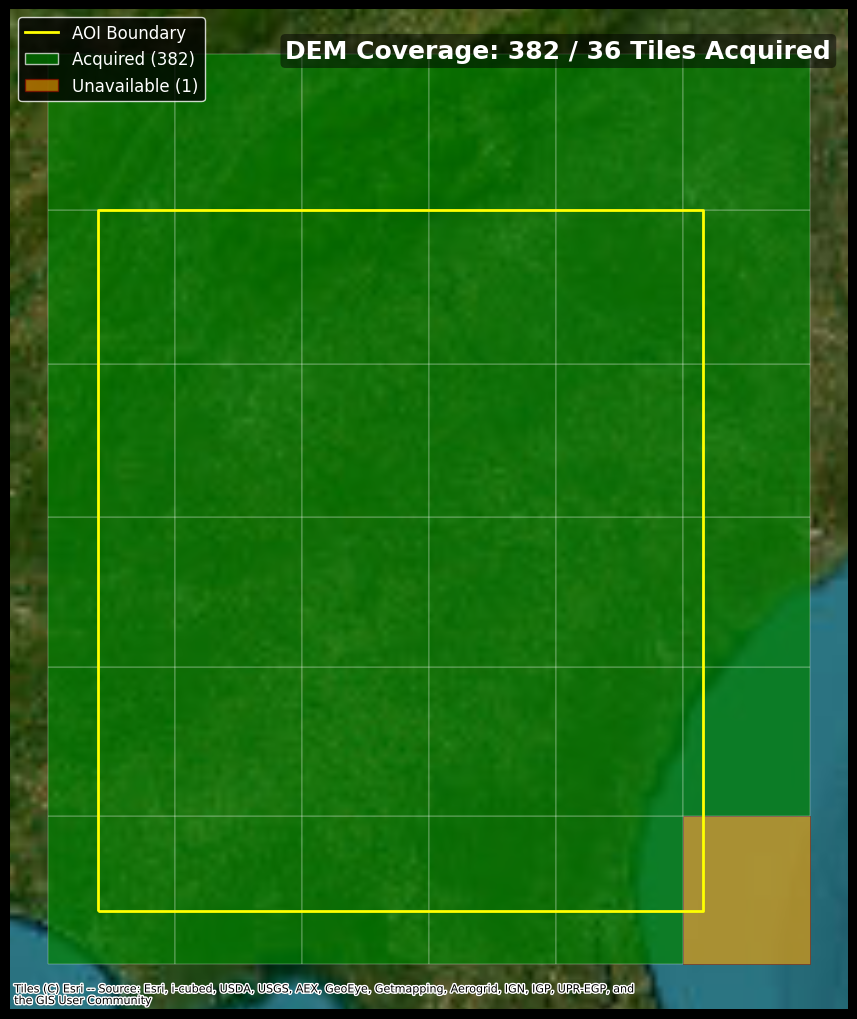

In [12]:
# === 6. DEM Post-flight Check & Validation ===

def verify_dem_coverage(required_keys: list[str], candidates: gpd.GeoDataFrame, aoi: gpd.GeoDataFrame, dem_dir: Path):
    """
    Verifies which DEM files were successfully downloaded and validates their correctness.
    Generates a final coverage map with professional styling.
    """
    log.info("Running post-flight verification for DEM data...")

    # Only scan .tif files and use regex extraction
    tif_files = list(dem_dir.glob("*.tif"))
    on_disk_keys_after = set()
    for p in tif_files:
        match = re.search(r'(n|s)\d{2}(w|e)\d{3}', p.name)
        if match:
            on_disk_keys_after.add(match.group(0))

    missing_after = sorted(set(required_keys) - on_disk_keys_after)

    log.info("=" * 60)
    log.info("DEM POST-FLIGHT VALIDATION")
    log.info("=" * 60)
    log.info(f"  Tiles Required: {len(required_keys)}")
    log.info(f"   Tiles On Disk: {len(on_disk_keys_after)}")
    log.info(f"   Still Missing: {len(missing_after)}")
    log.info("=" * 60)

    if not missing_after:
        log.info("✅ All required DEM tiles are now on disk.")
    else:
        log.warning(f"⚠️  {len(missing_after)} tiles still missing (likely unavailable from source)")

    log.info("Generating final DEM coverage map...")

    # Convert to Web Mercator for basemap compatibility
    aoi_mercator = aoi.to_crs(WEB_MAP_CRS)
    candidates_mercator = candidates.to_crs(WEB_MAP_CRS)

    # Create figure with dark background
    fig, ax = plt.subplots(figsize=(14, 10), facecolor='black')
    ax.set_facecolor('black')

    # Plot acquired tiles in green
    acquired_geoms_mercator = candidates_mercator[candidates_mercator['key'].isin(on_disk_keys_after)]
    if not acquired_geoms_mercator.empty:
        acquired_geoms_mercator.plot(ax=ax, facecolor="green", edgecolor="white",
                                     alpha=0.7, linewidth=0.3, zorder=2)

    # Plot unavailable tiles in orange/red
    unavailable_geoms_mercator = candidates_mercator[candidates_mercator['key'].isin(missing_after)]
    if not unavailable_geoms_mercator.empty:
        unavailable_geoms_mercator.plot(ax=ax, facecolor="orange", edgecolor="darkred",
                                        alpha=0.6, linewidth=0.5, zorder=1)

    # Plot AOI boundary on top in yellow
    aoi_mercator.boundary.plot(ax=ax, color="yellow", linewidth=2, zorder=3)

    # Add basemap for context
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, zoom=5)

    # Add legend
    handles = [
        Line2D([0], [0], color="yellow", lw=2, label="AOI Boundary"),
        Rectangle((0, 0), 1, 1, facecolor="green", edgecolor="white",
                 alpha=0.7, label=f"Acquired ({len(on_disk_keys_after)})"),
        Rectangle((0, 0), 1, 1, facecolor="orange", edgecolor="darkred",
                 alpha=0.6, label=f"Unavailable ({len(missing_after)})")
    ]
    ax.legend(handles=handles, loc='upper left', fontsize=12,
             facecolor='black', edgecolor='white', labelcolor='white')

    # Add title
    ax.text(0.98, 0.97,
            f"DEM Coverage: {len(on_disk_keys_after)} / {len(required_keys)} Tiles Acquired",
            transform=ax.transAxes, color='white', fontsize=18,
            fontweight='bold', ha='right', va='top',
            bbox=dict(facecolor='black', alpha=0.5, edgecolor='none', boxstyle='round,pad=0.2'))

    # Clean up axes
    ax.set_axis_off()
    fig.tight_layout(pad=0)

    figure_path = REPORTS_DIR / "dem_post_download_coverage.png"
    fig.savefig(figure_path, dpi=300, bbox_inches='tight', pad_inches=0, facecolor='black')
    log.info(f"Saved final coverage map to {figure_path}")
    plt.show()

# --- Execute Verification ---
verify_dem_coverage(required_dem_keys, candidate_tiles_gdf, master_aoi_wgs84, DEM_OUT_DIR)